## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV


In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.optimize import minimize
from sklearn.model_selection import TimeSeriesSplit

# 1. Подготовка

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv')

In [4]:
taxi[:4]

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [6]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [7]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null datetime64[ns]
num_orders    26496 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


# 2. Анализ

In [8]:
taxi.index = taxi['datetime']
taxi.index.is_monotonic

True

In [9]:
#taxi = taxi.drop(['datetime'], axis = 1)
taxi = taxi.resample('1H').sum()

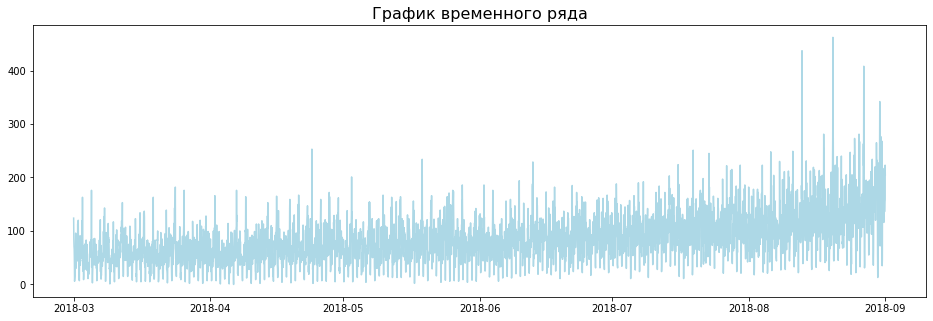

In [10]:
plt.figure(figsize=(16,5))
plt.title('График временного ряда', fontsize=16)
plt.plot( taxi.index, 'num_orders', data=taxi, color='lightblue')
plt.show()

In [11]:
def day(data, rolling):
    day = data.resample('1H').sum()
    #day['mean'] = day['num_orders'].rolling(rolling).mean()
    day['std'] = day['num_orders'].rolling(rolling).std()
    day.plot(figsize=(16,5), title = 'График временного ряда')
    plt.show()
    

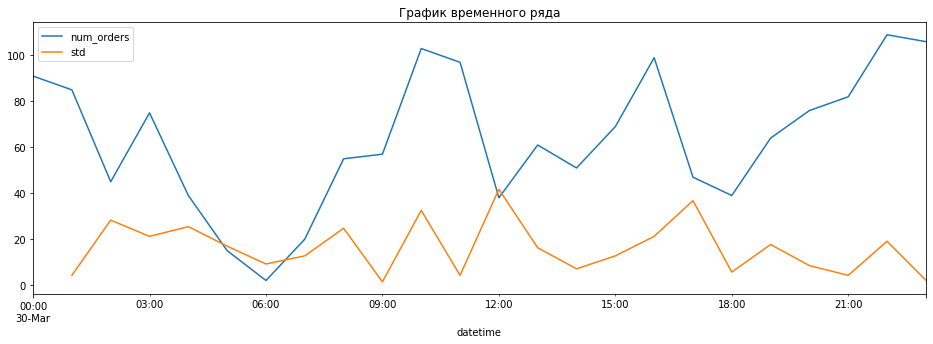

In [12]:
day(taxi['2018-03-30':'2018-03-30'], 2)

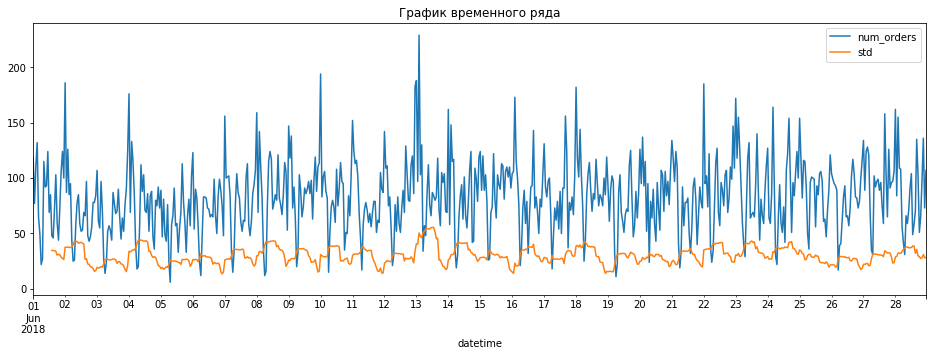

In [13]:
day(taxi['2018-06-01':'2018-06-28'], 15)

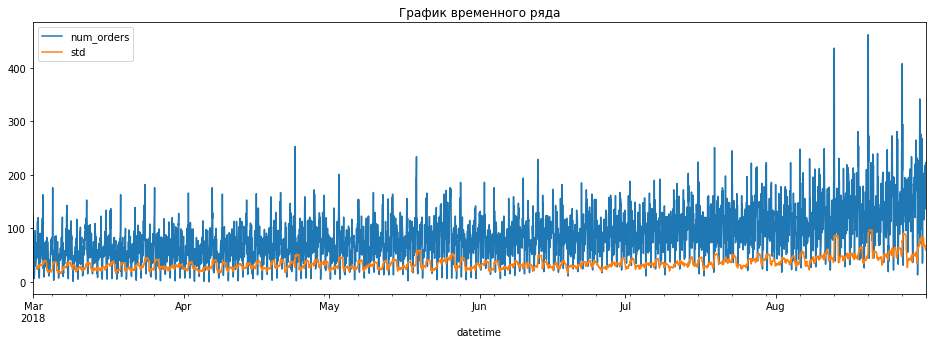

In [14]:
day(taxi['2018-03-01':'2018-09-24'], 20)

In [15]:
def moving_average(series, n):
    rolling_mean = series.rolling(window=n).mean()
    plt.figure(figsize=(16,5))
    plt.title("Скользящее среднее\n Размер окна = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

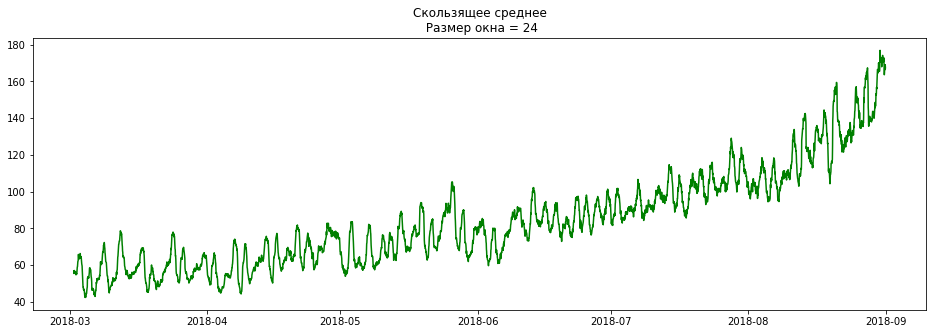

In [16]:
moving_average(taxi.num_orders, 24)

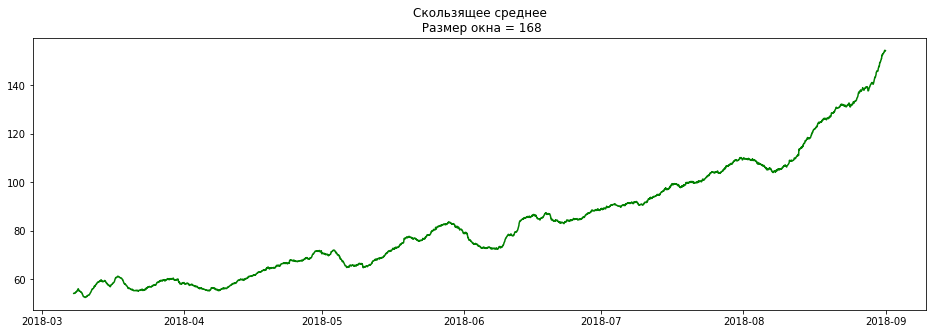

In [17]:
moving_average(taxi.num_orders, 24*7)

## Ряд не стационарен

# 3. Обучение

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    data = data.dropna()
    
    features = data.drop(['num_orders'], axis = 1)
    target = data['num_orders']
    
    features_train, features_test, target_train, target_test = train_test_split(features,  target,
                                                                                  shuffle=False, test_size=0.2)
    
    return features, target, data, features_train, features_test, target_train, target_test

In [21]:
features, target, data, features_train, features_test, target_train, target_test = make_features(taxi, 100, 5)

### Линейная регрессия

In [22]:
p=

SyntaxError: invalid syntax (<ipython-input-22-6c2fe2afb67f>, line 1)

In [23]:
features_train_short = features_train.loc['2018-07-01']
target_train_short = target_train.loc['2018-07-01']
#features_test_short = features_test.loc['2018-07-01']
#target_test_short = target_test.loc['2018-07-01']

In [24]:
features_test

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-07-27 00:00:00,2018,7,27,4,117.0,105.0,90.0,69.0,71.0,84.0,...,124.0,123.0,182.0,135.0,245.0,155.0,105.0,104.0,99.0,90.4
2018-07-27 01:00:00,2018,7,27,4,222.0,117.0,105.0,90.0,69.0,71.0,...,102.0,124.0,123.0,182.0,135.0,245.0,155.0,105.0,104.0,120.6
2018-07-27 02:00:00,2018,7,27,4,108.0,222.0,117.0,105.0,90.0,69.0,...,39.0,102.0,124.0,123.0,182.0,135.0,245.0,155.0,105.0,128.4
2018-07-27 03:00:00,2018,7,27,4,161.0,108.0,222.0,117.0,105.0,90.0,...,36.0,39.0,102.0,124.0,123.0,182.0,135.0,245.0,155.0,142.6
2018-07-27 04:00:00,2018,7,27,4,131.0,161.0,108.0,222.0,117.0,105.0,...,88.0,36.0,39.0,102.0,124.0,123.0,182.0,135.0,245.0,147.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,195.0,174.0
2018-08-31 20:00:00,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,165.0,174.6
2018-08-31 21:00:00,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,133.0,192.0,157.0,173.0,152.0,96.0,152.0,111.0,182.0,182.2


In [ ]:
model_Linear = LinearRegression().fit(features_train, target_train)
model_Linear_predict = model_Linear.predict(features_train)
print('RMSE:', mean_squared_error(target_train, model_Linear_predict)**0.5)

In [ ]:
model_Linear = LinearRegression().fit(features_train_short, target_train_short)
model_Linear_predict_short = model_Linear.predict(features_train_short)
print('RMSE:', mean_squared_error(target_train_short, model_Linear_predict_short)**0.5)

### Градиентный бустинг

In [ ]:
gradient_model = GradientBoostingRegressor(random_state=12345).fit(features_train, target_train)
gradient_model_predict = gradient_model.predict(features_train)
print('RMSE:', mean_squared_error(target_train, gradient_model_predict)**0.5)

### XGBoost

In [ ]:
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test, label=target_test)

params = {'max_depth':10, 
         'eta':.3,
         'silent': 1,
        }
num_round = 100

#cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=num_round)

In [ ]:
bst = xgb.train(params, dtrain, num_boost_round=10)

In [ ]:
model_XGBoost_predictions = bst.predict(dtrain)
print('RMSE',mean_squared_error(target_train, model_XGBoost_predictions)**0.5)

### CatBoost

In [ ]:
def RMSE(y_actual, y_predict):
    return np.sqrt(mean_squared_error(target_train, model_XGBoost_predictions)**0.5)

my_scorer = make_scorer(RMSE, greater_is_better = False)

params_cat = {'iterations': [100], 'depth':[x for x in range (2,16,2)],}

grid_cat = GridSearchCV(estimator = CatBoostRegressor(random_state=1234),
    param_grid = params_cat, cv=2, verbose=False, n_jobs=-1, scoring = my_scorer)


#grid_cat.fit(features_train, target_train)
#grid_cat.best_params_

In [ ]:
model_CatBoost = CatBoostRegressor(iterations = 100, depth = 12,  verbose=1000,
                          loss_function='RMSE').fit(features_train, target_train)
model_CatBoost_predictions = model_CatBoost.predict(features_train)
print('RMSE:', mean_squared_error(target_train, model_CatBoost_predictions)**0.5)

In [ ]:
#SARIMA

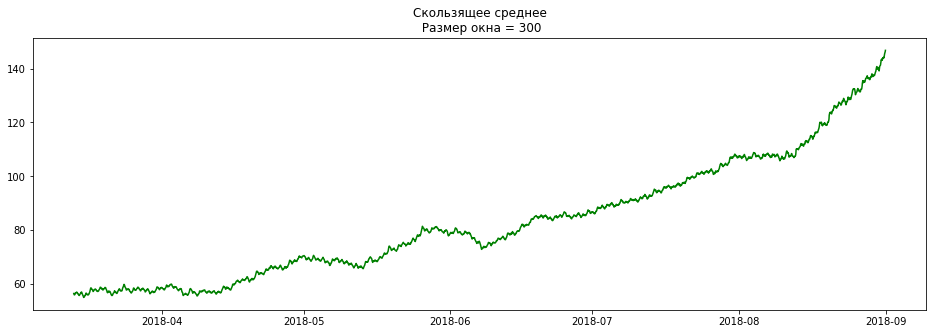

In [35]:
moving_average(taxi.num_orders, 300)

In [49]:
res = sm.tsa.adfuller(taxi['num_orders'],regression='ct')
print('p-value:{}'.format(res[1]))

p-value:1.2583924361803236e-11


In [50]:
res = sm.tsa.adfuller(taxi['num_orders']['2018-05-01':'2018-07-01'],regression='ct')
print('p-value:{}'.format(res[1]))

p-value:0.0005657457519778519


In [55]:
res = sm.tsa.adfuller(taxi['num_orders'][:'2018-08-15'],regression='ct')
print('p-value:{}'.format(res[1]))

p-value:1.5308023884678396e-17


In [69]:
tr_start,tr_end = '2018-04-01','2018-08-01'
te_start,te_end = '2018-08-01','2018-09-01'
tra = taxi['num_orders'][tr_start:tr_end].dropna()
tes = taxi['num_orders'][te_start:te_end].dropna()

In [73]:
sarima = sm.tsa.statespace.SARIMAX(tra,order=(7,1,7),seasonal_order=(7,1,7,1),
                                enforce_stationarity=False, enforce_invertibility=False,freq='D')
sarima.summary()

ValueError: The given frequency argument is incompatible with the given index.

# 4. Тестирование

In [ ]:
model_Linear_predict = model_Linear.predict(features_test)
print('RMSE:', mean_squared_error(target_test, model_Linear_predict)**0.5)

In [ ]:
model_Linear_predict_short = model_Linear.predict(features_test_short)
print('RMSE:', mean_squared_error(target_test_short, model_Linear_predict_short)**0.5)

In [ ]:
gradient_model_predict = gradient_model.predict(features_test)
print('RMSE:', mean_squared_error(target_test, gradient_model_predict)**0.5)

In [ ]:
model_CatBoost_predictions = model_CatBoost.predict(features_test)
print('RMSE:', mean_squared_error(target_test, model_CatBoost_predictions)**0.5)

In [ ]:
model_XGBoost_predictions = bst.predict(dtest)
print('RMSE',mean_squared_error(target_test, model_XGBoost_predictions)**0.5)

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48